<a href="https://colab.research.google.com/github/jalbury/machine-learning/blob/master/HW_4/HW4_Problem3b_John_Albury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of changes

This is the second of two notebooks that will modify Dr. Wocjan's code to use a different convolution base for feature extraction. Specifically, I changed the convolutional base of the model from [VGG16](https://keras.io/applications/#vgg16) to [InceptionV3](https://keras.io/applications/#inceptionv3).

For this second notebook, I used a classifier with a single `Dense` layer with 256 neurons. The results were a validation loss of 0.15 and a validation accuracy of 0.89. Although my changes reduced the validation loss by about $1\over2$, the validation accuracy was nearly the same.

# Fine-tuning InceptionV3 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the InceptionV3 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-18 19:21:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   117MB/s    in 0.6s    

2020-04-18 19:21:20 (117 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with InceptionV3 convolution base and custom densely connected layers

### Load the convolutional base

In [5]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


87916544/87910968 [==============================] - 1s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 31s 315ms/step - loss: 0.5788 - acc: 0.6650 - val_loss: 0.0073 - val_acc: 0.9280
Epoch 2/30
100/100 [==============================] - 20s 201ms/step - loss: 0.4698 - acc: 0.7660 - val_loss: 0.8040 - val_acc: 0.9410
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.4465 - acc: 0.7850 - val_loss: 0.1111 - val_acc: 0.9340
Epoch 4/30
100/100 [==============================] - 20s 198ms/step - loss: 0.4602 - acc: 0.7835 - val_loss: 0.2860 - val_acc: 0.9490
Epoch 5/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4487 - acc: 0.7805 - val_loss: 0.7371 - val_acc: 0.9330
Epoch 6/30
100/100 [==============================] - 20s 198ms/step - loss: 0.4422 - acc: 0.7870 - val_loss: 0.1358 - val_acc: 0.9510
Epoch 7/30
100/100 [==============================] - 20s 198ms/step - loss: 0.4246 - acc: 0.7910 - val_lo

## Display curves of loss and accuracy during training

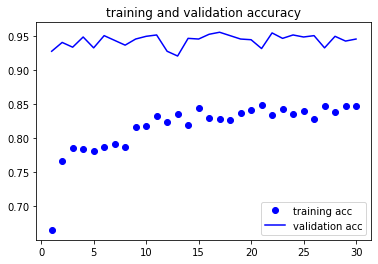

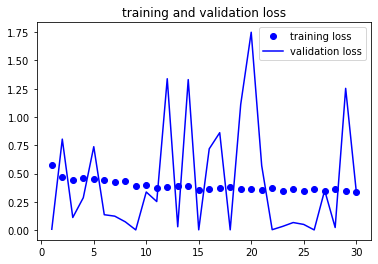

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv2d_188':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 281ms/step - loss: 0.3197 - acc: 0.8500 - val_loss: 0.1387 - val_acc: 0.9290
Epoch 2/100
100/100 [==============================] - 22s 215ms/step - loss: 0.3026 - acc: 0.8600 - val_loss: 0.4961 - val_acc: 0.9100
Epoch 3/100
100/100 [==============================] - 22s 215ms/step - loss: 0.3418 - acc: 0.8475 - val_loss: 0.1626 - val_acc: 0.9070
Epoch 4/100
100/100 [==============================] - 21s 215ms/step - loss: 0.3304 - acc: 0.8530 - val_loss: 0.3138 - val_acc: 0.8940
Epoch 5/100
100/100 [==============================] - 22s 215ms/step - loss: 0.3148 - acc: 0.8570 - val_loss: 0.2443 - val_acc: 0.8820
Epoch 6/100
100/100 [==============================] - 21s 215ms/step - loss: 0.3379 - acc: 0.8515 - val_loss: 0.1363 - val_acc: 0.8950
Epoch 7/100
100/100 [==============================] - 21s 215ms/step - loss: 0.3334 - acc: 0.8525 - val_loss: 0.3304 - val_acc: 0.8800
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

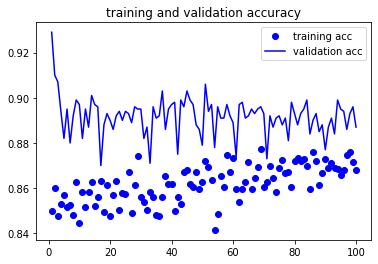

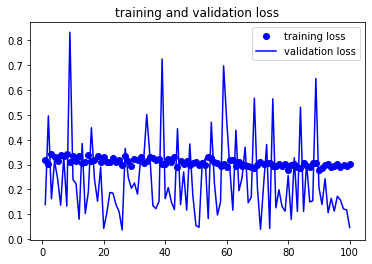

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.1530611664056778
Validation accuracy: 0.8870000243186951
